# Initial character analysis

We're going to go line by line through Patrick's character file, keeping only the lines that have docids attached. In each case we'll translate the docid into a date.


In [33]:
# first, some common imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from scipy.stats import pearsonr

In [17]:
ficmeta = pd.read_csv('../meta/filteredfictionmeta.tsv', sep = '\t', index_col = 'docid')
ficmeta = ficmeta[~ficmeta.index.duplicated(keep='first')]
charmeta = pd.read_csv('../meta/patchars.csv')
charmeta.head()

,docid,charid,charactername,gender,age,sequence,class,rankinbook,role,livelihood,comments,Unnamed: 11
0,mdp.39015013962207,Mrs.Dalloway,Clarissa Dalloway,f,52,NaN,middle class|rich,0.6,protagonist,marriage,NaN,NaN
1,mdp.39015013962207,Mr.Dalloway|Richard,Richard Dalloway,m,Middle-aged,NaN,rich|high official,0.6,love interest,NaN,NaN,NaN
2,mdp.39015013962207,Mr.Smith|Septimus,SeptimusSmith,m,adult,NaN,military|cultured,0.4,protagonist,NaN,disabled,NaN
3,mdp.39015013962207,William,Sir William Bradshaw,m,Middle-aged,NaN,rich|peer|professional,0.7,NaN,NaN,Self-made,NaN
4,mdp.39015013962207,Rezia|Mrs.Smith,Lucrezia Smith,f,adult,NaN,middle class,0.4,love interest,marriage,NaN,NaN


In [8]:
print(charmeta.shape)
print('We have ' + str(charmeta.shape[0]) + ' rows.')

(599, 12)
We have 599 rows.


Let's see how many rows we lose when we drop those without docids.

In [14]:
charmeta = charmeta.dropna(subset = ['docid'])
print('Now we have ' + str(charmeta.shape[0]) + ' rows.')

Now we have 550 rows.


In [18]:
def getdate(adocid):
    global ficmeta
    if adocid not in ficmeta.index:
        return 0
    else:
        return int(ficmeta.loc[adocid, 'inferreddate'])

In [19]:
newcol = charmeta.docid.map(getdate)
charmeta = charmeta.assign(date = newcol)

In [20]:
charmeta.head()

,docid,charid,charactername,gender,age,sequence,class,rankinbook,role,livelihood,comments,Unnamed: 11,date
0,mdp.39015013962207,Mrs.Dalloway,Clarissa Dalloway,f,52,NaN,middle class|rich,0.6,protagonist,marriage,NaN,NaN,1925
1,mdp.39015013962207,Mr.Dalloway|Richard,Richard Dalloway,m,Middle-aged,NaN,rich|high official,0.6,love interest,NaN,NaN,NaN,1925
2,mdp.39015013962207,Mr.Smith|Septimus,SeptimusSmith,m,adult,NaN,military|cultured,0.4,protagonist,NaN,disabled,NaN,1925
3,mdp.39015013962207,William,Sir William Bradshaw,m,Middle-aged,NaN,rich|peer|professional,0.7,NaN,NaN,Self-made,NaN,1925
4,mdp.39015013962207,Rezia|Mrs.Smith,Lucrezia Smith,f,adult,NaN,middle class,0.4,love interest,marriage,NaN,NaN,1925


## Initial guess about polarization

How widely are "rankinbooks" scattered? One way to measure is to take the standard deviation for each volume.

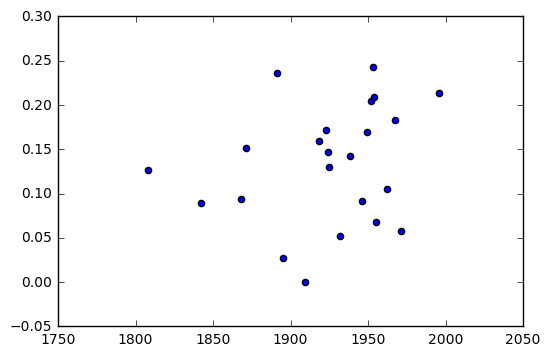

(0.23444905290923715, 0.2815817712282902)


In [34]:
x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    deviation = np.std(group.rankinbook)
    x.append(thisdate)
    y.append(deviation)

plt.scatter(x, y)
plt.show()
print(pearsonr(x, y))   

That wasn't a statistically significant pattern.

## Let's get a list of classes


In [25]:
classlist = Counter()

for c in charmeta['class']:
    classes = c.split('|')
    for aclass in classes:
        classlist[aclass] += 1

for name, count in classlist.items():
    print(name, count)
        
    

performer 4
artist 4
banker 3
military 57
high officla 1
professional 70
domestic servant 1
peer 71
merchant 1
criminal 9
manager 1
farmer 20
landed gentry 26
classless 5
rich 111
high official 54
poor 41
artisan 2
landlord 2
clergy 15
wealthy 1
homeless 17
orphan 1
middle class 176
cultured 45
upper class 11
domestic help  18
proprietor 18
cultured  1
domestic help 8
disabled 8
slave 7
sex worker 6
working class 38
supernatural being 19
student 30


In [43]:
# list of ages

agelist = Counter()

for a in charmeta['age']:
    agelist[a] += 1

for name, count in agelist.items():
    print(name, count)
        

nan 26
young adult 58
elderly|immoral 1
elderly 40
immortal 14
52 1
Middle-aged 227
elderly|immortal 1
adult 199
child 32


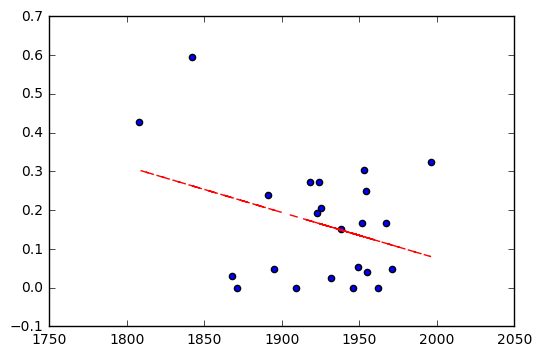

(-0.33748532843911139, 0.1152852275560477)


In [41]:
upper = {'rich', 'landed gentry', 'upper class', 'peer', 'wealthy', 'high official'}
lower = {'poor', 'working class', 'domestic help', 'slave', 'sex worker', 'criminal', 'homeless'}

x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    
    totaltags = 0
    uppertags = 0
    
    for c in group['class']:
        classes = c.split('|')
        doneyet = False
        for aclass in classes:
            totaltags += 1
            if aclass in upper and not doneyet:
                uppertags += 1
                doneyet = True
    
    x.append(thisdate)
    y.append(uppertags/totaltags)

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()
print(pearsonr(x, y)) 

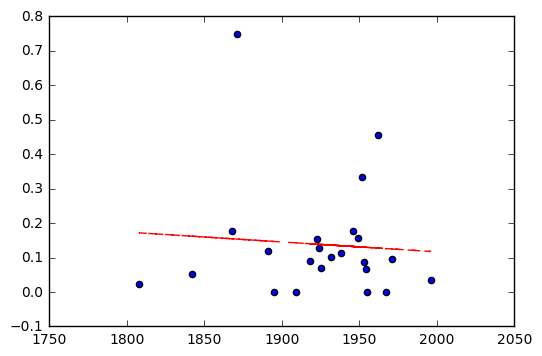

(-0.074960357794863403, 0.73391067130376109)


In [45]:
x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    
    totaltags = 0
    lowertags = 0
    
    for c in group['class']:
        classes = c.split('|')
        doneyet = False
        for aclass in classes:
            totaltags += 1
            if aclass in lower and not doneyet:
                lowertags += 1
                doneyet = True
    
    x.append(thisdate)
    y.append(lowertags/totaltags)

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()
print(pearsonr(x, y)) 

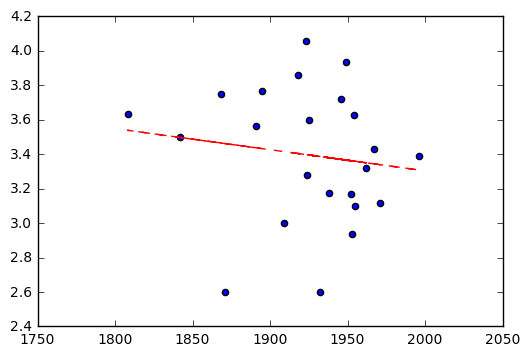

(-0.13864540444254328, 0.52810695400904784)


In [46]:
x = []
y = []

for docid, group in charmeta.groupby('docid'):
    thisdate = np.mean(group.date)
    if thisdate < 1700:
        continue
    
    ages = [3]
    
    for a in group['age']:
        if a == 'child':
            ages.append(1)
        elif a == 'young adult':
            ages.append(2)
        elif a == 'adult':
            ages.append(3)
        elif a == 'Middle-aged':
            ages.append(4)
        elif a == 'elderly':
            ages.append(5)
            
    
    x.append(thisdate)
    y.append(np.mean(ages))

plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()
print(pearsonr(x, y)) 